In [1]:
from pycaret.regression import load_model, predict_model

In [32]:
import re
import pandas as pd

def correct_lgbm_names(df) -> pd.DataFrame:
    # Change columns names ([LightGBM] Do not support special JSON characters in feature name.)
    new_names = {col: re.sub(r"[^A-Za-z0-9_]+", "", col) for col in df.columns}
    new_n_list = list(new_names.values())
    # [LightGBM] Feature appears more than one time.
    new_names = {
        col: f"{new_col}_{i}" if new_col in new_n_list[:i] else new_col
        for i, (col, new_col) in enumerate(new_names.items())
    }
    return df.rename(columns=new_names)
    

def correct_features(original_df, model_features):
    
    corrected_df = correct_lgbm_names(original_df)
    
    # Add columns which (for some reason) are not present but are required by the trained model's pipeline
    # Default value "None"
    for feat in model_features:
        found_in_model = feat in corrected_df
        if not found_in_model:
            print(feat)
            if feat != 'label':
                corrected_df[feat] = None
    return corrected_df

In [33]:
from src.featurizers.tsfresh import TsfreshFeaturizer

def featurize_stream_df(stream_df, window, horizon):
    featurizer = TsfreshFeaturizer(stream_df.tail(window), window, horizon, plot_chunks=False, minimal_features=False)
    featurizer.chunks = 1
    featurizer.create_feature_dataframe()
    return featurizer.feature_dataframe

In [56]:
from pycaret.regression import load_model, predict_model, pull
from src.bgc_providers.ohio_bgc_provider import OhioBgcProvider
from datetime import datetime, timedelta
import pandas as pd

model = load_model('models/559_6_6_1_LGBMRegressor_8ef033d3-ac4b-47ba-8231-fb49991f8b7f')
saved_model_features = model.feature_names_in_

provider = OhioBgcProvider()
measurements = provider.tsfresh_dataframe()

stream = pd.DataFrame()

max_data = 20
meas_list = []
predictions = []
for counter in range(max_data):
    measurement = measurements.iloc[counter]
    meas_list.append(measurement)
    if len(meas_list) >= 6:
        last_n = meas_list[-6:]
        stream = pd.DataFrame(last_n).reset_index(drop=True)
        print(stream)
        features = featurize_stream_df(stream, 6, 6)
        # features
        prediction = predict_model(model, correct_features(features, saved_model_features)).prediction_label[0]
        print(prediction)
        predictions.append({
            'prediction_origin_time': measurement.date_time,
            'prediction_time': measurement.date_time + timedelta(minutes=6*5),
            'prediction_value': prediction,
        })
predictions

        


Transformation Pipeline and Model Successfully Loaded
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:17:00  2021-12-07    01:17:00  late night  0.00       101  a
1 2021-12-07 01:22:00  2021-12-07    01:22:00  late night  0.08        98  a
2 2021-12-07 01:27:00  2021-12-07    01:27:00  late night  0.17       104  a
3 2021-12-07 01:32:00  2021-12-07    01:32:00  late night  0.25       112  a
4 2021-12-07 01:37:00  2021-12-07    01:37:00  late night  0.33       120  a
5 2021-12-07 01:42:00  2021-12-07    01:42:00  late night  0.42       127  a


100%|██████████| 1/1 [00:05<00:00,  5.59s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
147.2868736564205
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:22:00  2021-12-07    01:22:00  late night  0.08        98  a
1 2021-12-07 01:27:00  2021-12-07    01:27:00  late night  0.17       104  a
2 2021-12-07 01:32:00  2021-12-07    01:32:00  late night  0.25       112  a
3 2021-12-07 01:37:00  2021-12-07    01:37:00  late night  0.33       120  a
4 2021-12-07 01:42:00  2021-12-07    01:42:00  late night  0.42       127  a
5 2021-12-07 01:47:00  2021-12-07    01:47:00  late night  0.50       135  a


100%|██████████| 1/1 [00:05<00:00,  5.80s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
156.47908464371034
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:27:00  2021-12-07    01:27:00  late night  0.17       104  a
1 2021-12-07 01:32:00  2021-12-07    01:32:00  late night  0.25       112  a
2 2021-12-07 01:37:00  2021-12-07    01:37:00  late night  0.33       120  a
3 2021-12-07 01:42:00  2021-12-07    01:42:00  late night  0.42       127  a
4 2021-12-07 01:47:00  2021-12-07    01:47:00  late night  0.50       135  a
5 2021-12-07 01:52:00  2021-12-07    01:52:00  late night  0.58       142  a


100%|██████████| 1/1 [00:05<00:00,  5.71s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
166.68020276724874
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:32:00  2021-12-07    01:32:00  late night  0.25       112  a
1 2021-12-07 01:37:00  2021-12-07    01:37:00  late night  0.33       120  a
2 2021-12-07 01:42:00  2021-12-07    01:42:00  late night  0.42       127  a
3 2021-12-07 01:47:00  2021-12-07    01:47:00  late night  0.50       135  a
4 2021-12-07 01:52:00  2021-12-07    01:52:00  late night  0.58       142  a
5 2021-12-07 01:57:00  2021-12-07    01:57:00  late night  0.67       140  a


100%|██████████| 1/1 [00:05<00:00,  5.50s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
137.05337284255495
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:37:00  2021-12-07    01:37:00  late night  0.33       120  a
1 2021-12-07 01:42:00  2021-12-07    01:42:00  late night  0.42       127  a
2 2021-12-07 01:47:00  2021-12-07    01:47:00  late night  0.50       135  a
3 2021-12-07 01:52:00  2021-12-07    01:52:00  late night  0.58       142  a
4 2021-12-07 01:57:00  2021-12-07    01:57:00  late night  0.67       140  a
5 2021-12-07 02:02:00  2021-12-07    02:02:00  late night  0.75       145  a


100%|██████████| 1/1 [00:05<00:00,  5.55s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
157.93776991982446
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:42:00  2021-12-07    01:42:00  late night  0.42       127  a
1 2021-12-07 01:47:00  2021-12-07    01:47:00  late night  0.50       135  a
2 2021-12-07 01:52:00  2021-12-07    01:52:00  late night  0.58       142  a
3 2021-12-07 01:57:00  2021-12-07    01:57:00  late night  0.67       140  a
4 2021-12-07 02:02:00  2021-12-07    02:02:00  late night  0.75       145  a
5 2021-12-07 02:07:00  2021-12-07    02:07:00  late night  0.83       148  a


100%|██████████| 1/1 [00:05<00:00,  5.64s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
147.30249923222078
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:47:00  2021-12-07    01:47:00  late night  0.50       135  a
1 2021-12-07 01:52:00  2021-12-07    01:52:00  late night  0.58       142  a
2 2021-12-07 01:57:00  2021-12-07    01:57:00  late night  0.67       140  a
3 2021-12-07 02:02:00  2021-12-07    02:02:00  late night  0.75       145  a
4 2021-12-07 02:07:00  2021-12-07    02:07:00  late night  0.83       148  a
5 2021-12-07 02:12:00  2021-12-07    02:12:00  late night  0.92       151  a


100%|██████████| 1/1 [00:05<00:00,  5.53s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
164.38411646343044
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:52:00  2021-12-07    01:52:00  late night  0.58       142  a
1 2021-12-07 01:57:00  2021-12-07    01:57:00  late night  0.67       140  a
2 2021-12-07 02:02:00  2021-12-07    02:02:00  late night  0.75       145  a
3 2021-12-07 02:07:00  2021-12-07    02:07:00  late night  0.83       148  a
4 2021-12-07 02:12:00  2021-12-07    02:12:00  late night  0.92       151  a
5 2021-12-07 02:17:00  2021-12-07    02:17:00  late night  1.00       150  a


100%|██████████| 1/1 [00:05<00:00,  5.78s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
149.20220954482735
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:57:00  2021-12-07    01:57:00  late night  0.67       140  a
1 2021-12-07 02:02:00  2021-12-07    02:02:00  late night  0.75       145  a
2 2021-12-07 02:07:00  2021-12-07    02:07:00  late night  0.83       148  a
3 2021-12-07 02:12:00  2021-12-07    02:12:00  late night  0.92       151  a
4 2021-12-07 02:17:00  2021-12-07    02:17:00  late night  1.00       150  a
5 2021-12-07 02:22:00  2021-12-07    02:22:00  late night  1.08       124  a


100%|██████████| 1/1 [00:05<00:00,  5.46s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
106.29905692776686
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:02:00  2021-12-07    02:02:00  late night  0.75       145  a
1 2021-12-07 02:07:00  2021-12-07    02:07:00  late night  0.83       148  a
2 2021-12-07 02:12:00  2021-12-07    02:12:00  late night  0.92       151  a
3 2021-12-07 02:17:00  2021-12-07    02:17:00  late night  1.00       150  a
4 2021-12-07 02:22:00  2021-12-07    02:22:00  late night  1.08       124  a
5 2021-12-07 02:27:00  2021-12-07    02:27:00  late night  1.17       130  a


100%|██████████| 1/1 [00:05<00:00,  5.52s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
118.9727198535413
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:07:00  2021-12-07    02:07:00  late night  0.83       148  a
1 2021-12-07 02:12:00  2021-12-07    02:12:00  late night  0.92       151  a
2 2021-12-07 02:17:00  2021-12-07    02:17:00  late night  1.00       150  a
3 2021-12-07 02:22:00  2021-12-07    02:22:00  late night  1.08       124  a
4 2021-12-07 02:27:00  2021-12-07    02:27:00  late night  1.17       130  a
5 2021-12-07 02:32:00  2021-12-07    02:32:00  late night  1.25       127  a


100%|██████████| 1/1 [00:05<00:00,  5.77s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
97.21683853830638
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:12:00  2021-12-07    02:12:00  late night  0.92       151  a
1 2021-12-07 02:17:00  2021-12-07    02:17:00  late night  1.00       150  a
2 2021-12-07 02:22:00  2021-12-07    02:22:00  late night  1.08       124  a
3 2021-12-07 02:27:00  2021-12-07    02:27:00  late night  1.17       130  a
4 2021-12-07 02:32:00  2021-12-07    02:32:00  late night  1.25       127  a
5 2021-12-07 02:37:00  2021-12-07    02:37:00  late night  1.33       121  a


100%|██████████| 1/1 [00:05<00:00,  5.65s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
93.14428727679184
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:17:00  2021-12-07    02:17:00  late night  1.00       150  a
1 2021-12-07 02:22:00  2021-12-07    02:22:00  late night  1.08       124  a
2 2021-12-07 02:27:00  2021-12-07    02:27:00  late night  1.17       130  a
3 2021-12-07 02:32:00  2021-12-07    02:32:00  late night  1.25       127  a
4 2021-12-07 02:37:00  2021-12-07    02:37:00  late night  1.33       121  a
5 2021-12-07 02:42:00  2021-12-07    02:42:00  late night  1.42       115  a


100%|██████████| 1/1 [00:05<00:00,  5.70s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
90.54716657998888
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:22:00  2021-12-07    02:22:00  late night  1.08       124  a
1 2021-12-07 02:27:00  2021-12-07    02:27:00  late night  1.17       130  a
2 2021-12-07 02:32:00  2021-12-07    02:32:00  late night  1.25       127  a
3 2021-12-07 02:37:00  2021-12-07    02:37:00  late night  1.33       121  a
4 2021-12-07 02:42:00  2021-12-07    02:42:00  late night  1.42       115  a
5 2021-12-07 02:47:00  2021-12-07    02:47:00  late night  1.50       111  a


100%|██████████| 1/1 [00:06<00:00,  6.10s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
93.99877780946768
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:27:00  2021-12-07    02:27:00  late night  1.17       130  a
1 2021-12-07 02:32:00  2021-12-07    02:32:00  late night  1.25       127  a
2 2021-12-07 02:37:00  2021-12-07    02:37:00  late night  1.33       121  a
3 2021-12-07 02:42:00  2021-12-07    02:42:00  late night  1.42       115  a
4 2021-12-07 02:47:00  2021-12-07    02:47:00  late night  1.50       111  a
5 2021-12-07 02:52:00  2021-12-07    02:52:00  late night  1.58       109  a


100%|██████████| 1/1 [00:05<00:00,  5.82s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
87.94435634273673


[{'prediction_origin_time': Timestamp('2021-12-07 01:42:00'),
  'prediction_time': Timestamp('2021-12-07 02:12:00'),
  'prediction_value': 147.2868736564205},
 {'prediction_origin_time': Timestamp('2021-12-07 01:47:00'),
  'prediction_time': Timestamp('2021-12-07 02:17:00'),
  'prediction_value': 156.47908464371034},
 {'prediction_origin_time': Timestamp('2021-12-07 01:52:00'),
  'prediction_time': Timestamp('2021-12-07 02:22:00'),
  'prediction_value': 166.68020276724874},
 {'prediction_origin_time': Timestamp('2021-12-07 01:57:00'),
  'prediction_time': Timestamp('2021-12-07 02:27:00'),
  'prediction_value': 137.05337284255495},
 {'prediction_origin_time': Timestamp('2021-12-07 02:02:00'),
  'prediction_time': Timestamp('2021-12-07 02:32:00'),
  'prediction_value': 157.93776991982446},
 {'prediction_origin_time': Timestamp('2021-12-07 02:07:00'),
  'prediction_time': Timestamp('2021-12-07 02:37:00'),
  'prediction_value': 147.30249923222078},
 {'prediction_origin_time': Timestamp('20

In [57]:
measurement_df = pd.DataFrame(meas_list)
measurement_df

,date_time,mock_date,time_of_day,part_of_day,time,bg_value,id
0,2021-12-07 01:17:00,2021-12-07,01:17:00,late night,0.00,101,a
1,2021-12-07 01:22:00,2021-12-07,01:22:00,late night,0.08,98,a
2,2021-12-07 01:27:00,2021-12-07,01:27:00,late night,0.17,104,a
3,2021-12-07 01:32:00,2021-12-07,01:32:00,late night,0.25,112,a
4,2021-12-07 01:37:00,2021-12-07,01:37:00,late night,0.33,120,a
5,2021-12-07 01:42:00,2021-12-07,01:42:00,late night,0.42,127,a
6,2021-12-07 01:47:00,2021-12-07,01:47:00,late night,0.50,135,a
7,2021-12-07 01:52:00,2021-12-07,01:52:00,late night,0.58,142,a
8,2021-12-07 01:57:00,2021-12-07,01:57:00,late night,0.67,140,a
9,2021-12-07 02:02:00,2021-12-07,02:02:00,late night,0.75,145,a


In [58]:
prediction_df = pd.DataFrame(predictions)
prediction_df

,prediction_origin_time,prediction_time,prediction_value
0,2021-12-07 01:42:00,2021-12-07 02:12:00,147.286874
1,2021-12-07 01:47:00,2021-12-07 02:17:00,156.479085
2,2021-12-07 01:52:00,2021-12-07 02:22:00,166.680203
3,2021-12-07 01:57:00,2021-12-07 02:27:00,137.053373
4,2021-12-07 02:02:00,2021-12-07 02:32:00,157.937770
5,2021-12-07 02:07:00,2021-12-07 02:37:00,147.302499
6,2021-12-07 02:12:00,2021-12-07 02:42:00,164.384116
7,2021-12-07 02:17:00,2021-12-07 02:47:00,149.202210
8,2021-12-07 02:22:00,2021-12-07 02:52:00,106.299057
9,2021-12-07 02:27:00,2021-12-07 02:57:00,118.972720


<Axes: xlabel='date_time'>

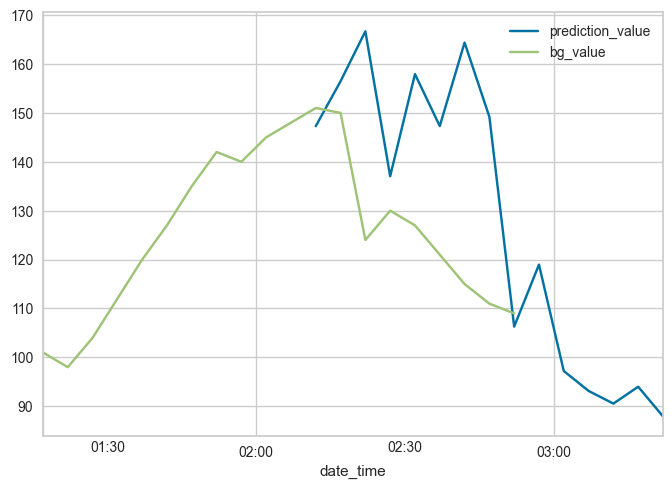

In [59]:
ax = prediction_df.plot(y='prediction_value', x='prediction_time')
measurement_df.plot(ax=ax, y='bg_value', x='date_time')


# Old

In [15]:
# from datetime import datetime, timedelta

# measurements.iloc[0].date_time + timedelta(minutes=6*5)

Timestamp('2021-12-07 01:47:00')

In [3]:
# from src.bgc_providers.ohio_bgc_provider import OhioBgcProvider
# test_provider = OhioBgcProvider()
# test_dataframe = test_provider.tsfresh_dataframe()
# mock_last_measurements = test_dataframe.head(6)
# mock_last_measurements
# features = featurize_stream_df(mock_last_measurements, 6, 6)
# features

,date_time,mock_date,time_of_day,part_of_day,time,bg_value,id
0,2021-12-07 01:17:00,2021-12-07,01:17:00,late night,0.00,101,a
1,2021-12-07 01:22:00,2021-12-07,01:22:00,late night,0.08,98,a
2,2021-12-07 01:27:00,2021-12-07,01:27:00,late night,0.17,104,a
3,2021-12-07 01:32:00,2021-12-07,01:32:00,late night,0.25,112,a
4,2021-12-07 01:37:00,2021-12-07,01:37:00,late night,0.33,120,a
5,2021-12-07 01:42:00,2021-12-07,01:42:00,late night,0.42,127,a


In [6]:
# model = load_model('models/559_6_6_1_LGBMRegressor_8ef033d3-ac4b-47ba-8231-fb49991f8b7f')
# saved_model_features = model.feature_names_in_
# a = predict_model(model, correct_features(features, saved_model_features))
# a.prediction_label[0]

Transformation Pipeline and Model Successfully Loaded


In [8]:
# from src.featurizers.tsfresh import TsfreshFeaturizer
# test_features = TsfreshFeaturizer(mock_last_measurements, 6, 6, plot_chunks=False, minimal_features=False)
# test_features.chunks = 1
# test_features.chunks

In [9]:
# test_features.create_feature_dataframe()
# features = test_features.feature_dataframe
# features

In [10]:
# import re
# new_names = {col: re.sub(r"[^A-Za-z0-9_]+", "", col) for col in features.columns}
# new_n_list = list(new_names.values())
# # [LightGBM] Feature appears more than one time.
# new_names = {
#     col: f"{new_col}_{i}" if new_col in new_n_list[:i] else new_col
#     for i, (col, new_col) in enumerate(new_names.items())
# }
# correct_features = features.rename(columns=new_names)
# # print(correct_features)
# for feat in saved_model_features:
#     found_in_model = feat in correct_features
#     if not found_in_model:
#         print(feat)
#         if feat != 'label':
#             correct_features[feat] = None